# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [104]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random, models

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
## Download Galaxy10 DECaLS (HDF5)
#! rm ./Galaxy10_DECals_64.h5
#! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
#data_path = "./Galaxy10_DECals_64.h5"
#
#print("Downloaded to:", data_path)


rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-11-26 17:25:58--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M   153KB/s    in 16m 6s  

2025-11-26 17:42:05 (161 KB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [2]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

Mounted at /content/drive
dataset already on google drive
copy data from google drive into colab
Data path: ./Galaxy10_DECals_64.h5


In [3]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [4]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


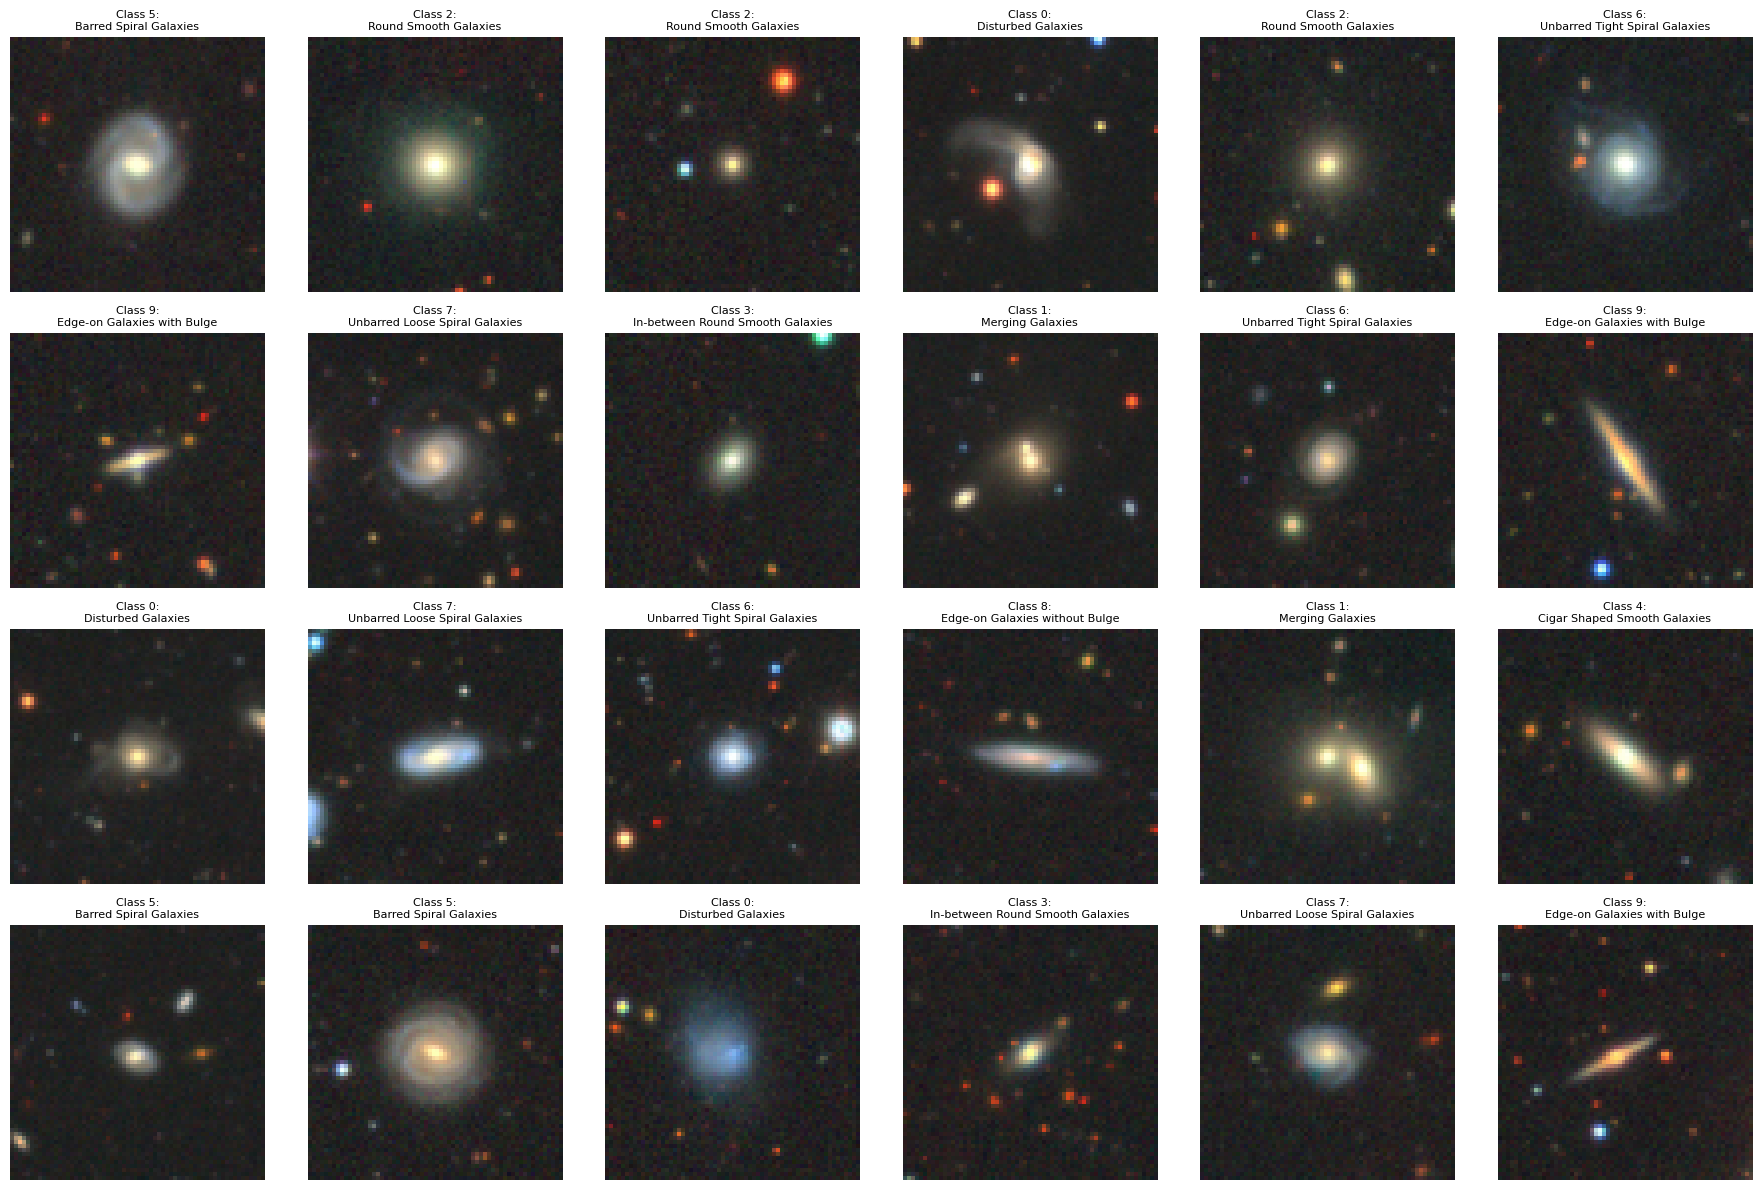

In [5]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [6]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 4

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 4, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (17402, 64, 64, 3)
Anomaly images: (334, 64, 64, 3)


In [7]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(0): 0, np.uint8(1): 1, np.uint8(2): 2, np.uint8(3): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [8]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8701, 64, 64, 3) (8701,)
Val standard:   (4350, 64, 64, 3) (4350,)
Test standard:  (4351, 64, 64, 3) (4351,)


In [11]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0.]


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [102]:
# custom data augmentation layer
data_augmentation = models.Sequential([
    # data augmentation
    layers.RandomRotation(0.3),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.1)
])

In [103]:
# CNN Classifier
classifier_input = keras.Input(shape=(64, 64, 3))
# Data augmentation for some more Regularization
x = data_augmentation(classifier_input)

# first layer
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
#x = layers.Activation("elu")(x)
x = layers.LeakyReLU(0.1)(x)    # for more stable training (because of less dead neurons)
x = layers.MaxPooling2D((2, 2))(x)  # get some sharper edges (especially for small spiral galaxy arms)
x = layers.Dropout(0.35)(x)

# second layer
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
#x = layers.Activation("elu")(x)
x = layers.LeakyReLU(0.1)(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.35)(x)

# third layer (needed: worse generalization because of low complexity, class 5 dominant)
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
#x = layers.Activation("elu")(x)
x = layers.LeakyReLU(0.1)(x)
x = layers.AveragePooling2D((2, 2))(x)  # Smooth out some sharpness to learn better generall shape
x = layers.Dropout(0.35)(x)

# classifier layer
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dense(64)(x) # like third layer
#x = layers.Activation("elu")(x)
x = layers.LeakyReLU(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.35)(x)
classifier_output = layers.Dense(9, activation="softmax")(x)

classifier_model = keras.Model(classifier_input, classifier_output, name="classifier")

# compile the model
classifier_model.compile(optimizer="adamW", loss="categorical_crossentropy", metrics=["accuracy"]) # Added Adam with Weight decay as regularization because of better generalization

# model summary
print(classifier_model.summary())

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_25            │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 324,169 (1.24 MB)

 Trainable params: 323,721 (1.23 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [97]:
# Train model
classifier_fit = classifier_model.fit(X_train_std, y_train_enc, epochs=50, batch_size=128,
                                      validation_data=(X_val_std, y_val_enc))

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2079 - loss: 2.4703 - val_accuracy: 0.1520 - val_loss: 3.9018
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.3061 - loss: 1.9476 - val_accuracy: 0.1520 - val_loss: 6.2552
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.3679 - loss: 1.7658 - val_accuracy: 0.1520 - val_loss: 7.8599
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3924 - loss: 1.6494 - val_accuracy: 0.1520 - val_loss: 6.1142
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4225 - loss: 1.5507 - val_accuracy: 0.1520 - val_loss: 6.0783
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4388 - loss: 1.5224 - val_accuracy: 0.1526 - val_loss: 5.8655
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4655 - loss: 1.4589 - val_accuracy: 0.1777 - val_loss: 3.6849
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4712 - loss: 1.4137 - val_accuracy: 0.1880 - v

In [98]:
# Evaluate test set
test_loss, test_acc = classifier_model.evaluate(X_test_std, y_test_enc)
print(f"Test accuracy: {test_acc:.5f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6786 - loss: 0.9733
Test accuracy: 0.68260


In [75]:
# Plot training history (accuracy and loss)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

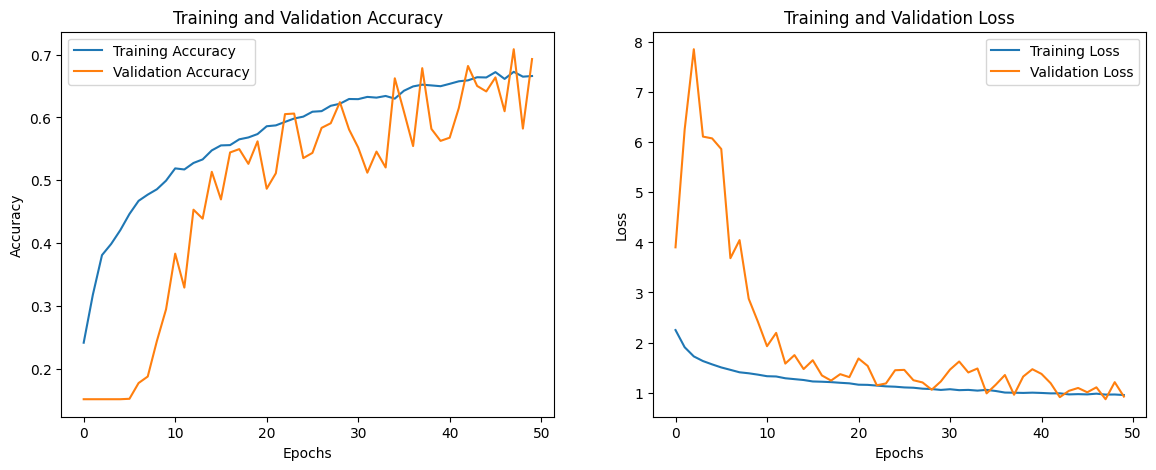

In [99]:
plot_training_history(classifier_fit)

In [34]:
# Plot ROC Curve
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(9):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


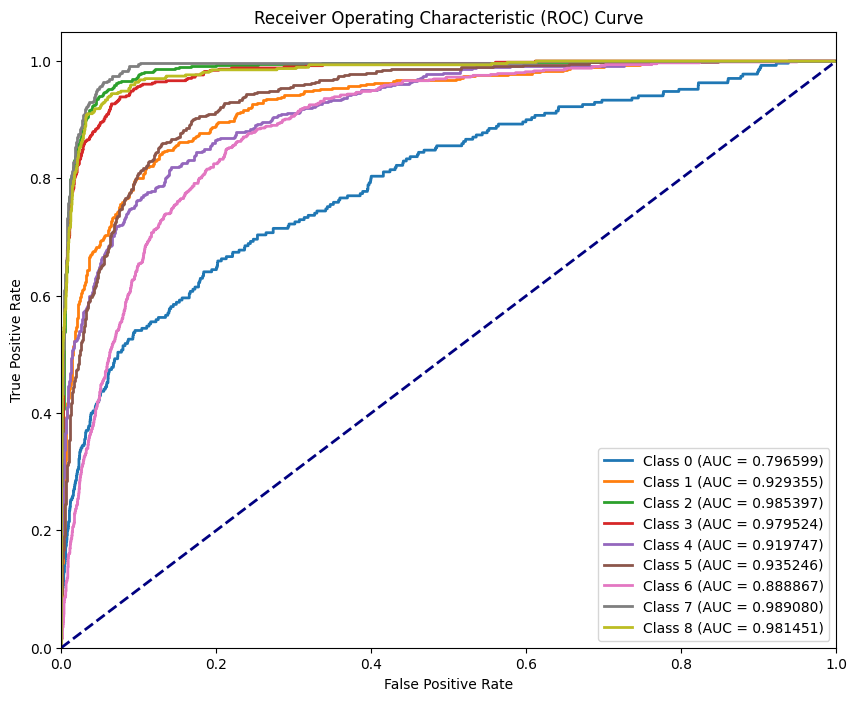

In [100]:
plot_roc_curve(X_test_std, y_test_enc, classifier_model)

In [19]:
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


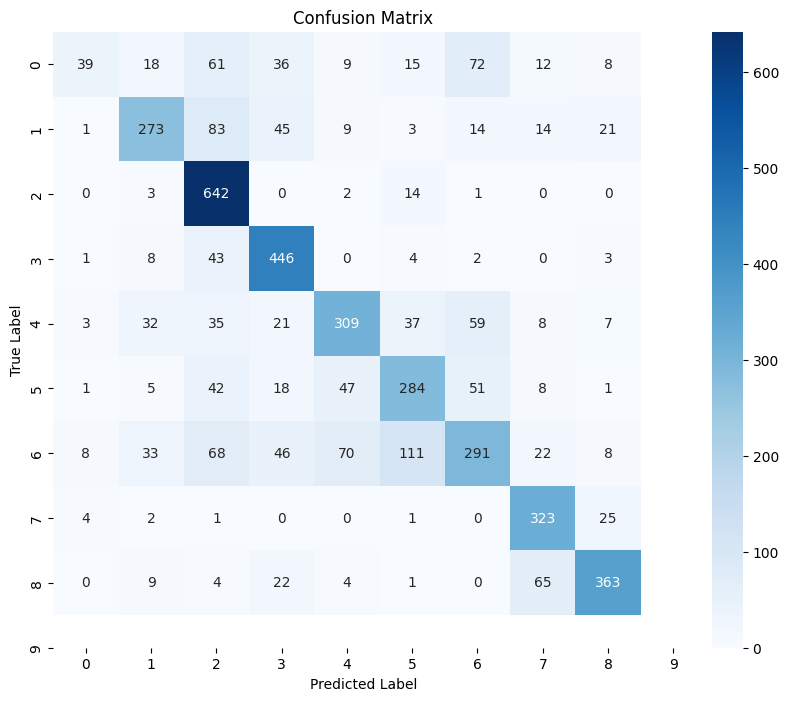

In [101]:
plot_confusion_matrix(X_test_std, y_test_enc, classifier_model)

## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

In [ ]:
from keras.src.layers.reshaping.up_sampling2d import UpSampling2D

# CNN model for standard dataset
autoencoder_model = models.Sequential([
    #data_augmentation,

    # encoder
    # first encoder layer
    layers.Conv2D(64, (3, 3), padding="same", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # second encoder layer
    layers.Conv2D(32, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # third encoder layer
    layers.Conv2D(16, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),

    # new representation space with bootleneck
    layers.Flatten(),
    layers.Dense(256),
    layers.Dense(64),
    layers.Dense(256),
    layers.Reshape((16, 16, 1)),

    # decoder
    # first decoder layer
    layers.Conv2D(8, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.UpSampling2D((2, 2)),

    # second decoder layer
    layers.Conv2D(32, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.UpSampling2D((2, 2)),

    # third decoder layer
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid"),
])

# compile the model
autoencoder_model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model summary
print(autoencoder_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,130,307 (4.31 MB)

 Trainable params: 1,129,875 (4.31 MB)

 Non-trainable params: 432 (1.69 KB)

None


In [ ]:
# Train model
autoencoder_fit = autoencoder_model.fit(
    X_train_std,
    X_train_std,
    epochs=20,
    batch_size=128,
    #epochs=50,#when using gpu
    #batch_size=128,#when using gpu
    validation_data=(X_val_std, X_val_std)
    )

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.3397 - loss: 0.3002 - val_accuracy: 0.3511 - val_loss: 0.1950
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3572 - loss: 0.0876 - val_accuracy: 0.3432 - val_loss: 0.1140
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.3582 - loss: 0.0376 - val_accuracy: 0.3642 - val_loss: 0.0877
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3746 - loss: 0.0346 - val_accuracy: 0.3718 - val_loss: 0.0714
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3775 - loss: 0.0332 - val_accuracy: 0.3747 - val_loss: 0.0620
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3796 - loss: 0.0327 - val_accuracy: 0.3805 - val_loss: 0.0504
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3839 - loss: 0.0320 - val_accuracy: 0.3827 - val_loss: 0.0429
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3845 - loss: 0.0318 - val_accuracy: 0.3855 -

In [ ]:
# plot training history
plt.plot(autoencoder_fit.history['loss'], label='Train Loss')
plt.plot(autoencoder_fit.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'autoencoder_fit' is not defined

In [ ]:
# reconstruct some images
X_out_test = autoencoder_model.predict(X_test_std)
X_out_anom = autoencoder_model.predict(anom_images)

# calculate MSE
mse_test = np.mean(np.square(X_test_std - X_out_test), axis=(1, 2, 3))
mse_anom = np.mean(np.square(anom_images - X_out_anom), axis=(1, 2, 3))

print(f"Reconstruction loss (MSE) test set: {mse_test}")
print(f"\nReconstruction loss (MSE) anomaly set: {mse_anom}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Reconstruction loss (MSE) test set: [0.12278278 0.10727609 0.11888062 ... 0.12787035 0.13124354 0.1336068 ]

Reconstruction loss (MSE) anomaly set: [0.13709685 0.13883552 0.13602841 0.13215465 0.134231   0.13662712
 0.12541469 0.13411912 0.13633704 0.12997627 0.13704476 0.13291475
 0.13207486 0.13885022 0.13541095 0.13079419 0.13687984 0.13739024
 0.13472917 0.12070114 0.13564545 0.13399999 0.13839695 0.1324017
 0.13814241 0.13387334 0.13952626 0.13677191 0.13356371 0.13856922
 0.13147551 0.1358905  0.12557124 0.13693379 0.13712069 0.13376914
 0.13602602 0.13407209 0.13590915 0.13917843 0.13556166 0.13446669
 0.13279573 0.13975603 0.12741523 0.13706791 0.13587251 0.13931735
 0.13332498 0.13663066 0.13885488 0.13568566 0.13248855 0.13234582
 0.12950591 0.13093486 0.1272589  0.12812512 0.13458963 0.12979269
 0.1278889  0.13743671 0.13512511 0.13922817 0.13817942 0.13182146
 0.13050329 0.13651169 0.13486873 

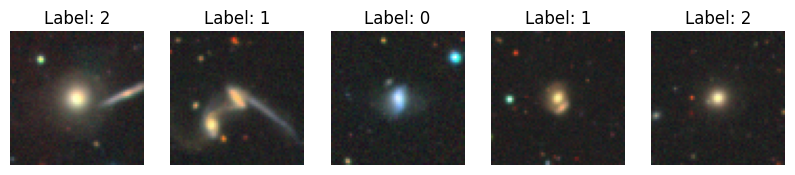

In [ ]:
# Visualize data set galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_test_std[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

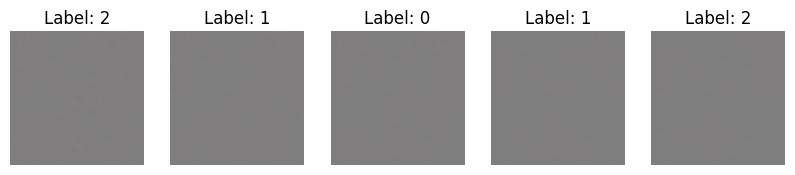

In [ ]:
# Visualize reconstructed galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_out_test[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

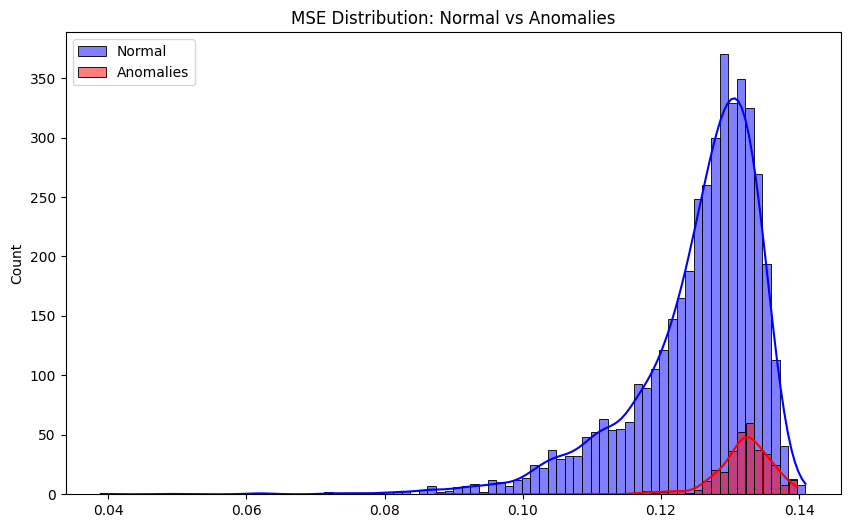

In [ ]:
# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_test, label='Normal', color='blue', kde=True)
sns.histplot(mse_anom, label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

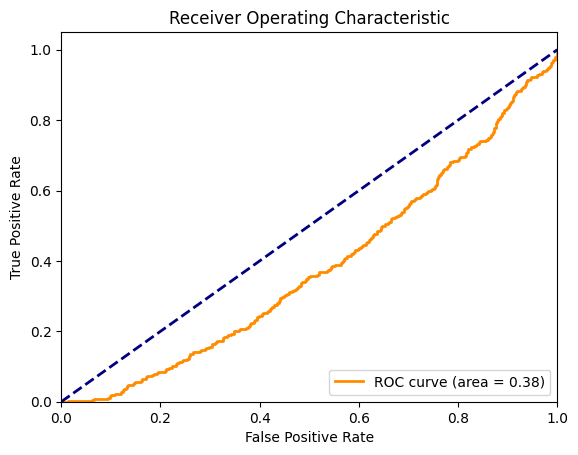

In [ ]:
# ROC curve
# combine normal and anomaly dataset
mse_all = np.concatenate([mse_test, mse_anom])
y_all = np.concatenate([np.zeros(len(mse_test)), np.ones(len(mse_anom))])

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_all, mse_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

In [ ]:
# Add Sampling class auch that we have a possibility to differentiate in Training
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define Encoder and Decoder
latent_dim = 2

# Encoder
encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(8, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 2, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 2))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │      4,624 │ conv2d_10[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4096)      │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │     32,776 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         18 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         18 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,332 (149.73 KB)

 Trainable params: 38,332 (149.73 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 16, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 16)     │           304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,347 (28.70 KB)

 Trainable params: 7,347 (28.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# VAE Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # --------- MSE reconstruction loss ---------
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)
            # --------- MSE reconstruction loss ---------
        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.mean_squared_error(data, reconstruction),
                axis=(1, 2),
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
# construct the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# training VAE model
vae_fit = vae.fit(X_train_std, epochs=30, batch_size=128, validation_data=X_val_std)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - kl_loss: 2.7526e-04 - loss: 49.2607 - reconstruction_loss: 49.2605 - val_kl_loss: 1.9246e-04 - val_loss: 46.0444 - val_reconstruction_loss: 46.0442
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 2.0895e-04 - loss: 44.3261 - reconstruction_loss: 44.3259 - val_kl_loss: 3.1874e-04 - val_loss: 41.6004 - val_reconstruction_loss: 41.6001
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - kl_loss: 4.1091e-04 - loss: 39.8441 - reconstruction_loss: 39.8437 - val_kl_loss: 9.0177e-04 - val_loss: 37.6891 - val_reconstruction_loss: 37.6882
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 0.0012 - loss: 36.4704 - reconstruction_loss: 36.4692 - val_kl_loss: 0.0023 - val_loss: 34.6503 - val_reconstruction_loss: 34.6481
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - kl_loss: 0.0027 - loss: 32.6272 - reconstruction_loss: 32.6246 - val_kl_loss: 0.0037 - val_loss: 32.5129 - val_reconstruction_loss: 32.5091
Epoch 6/30

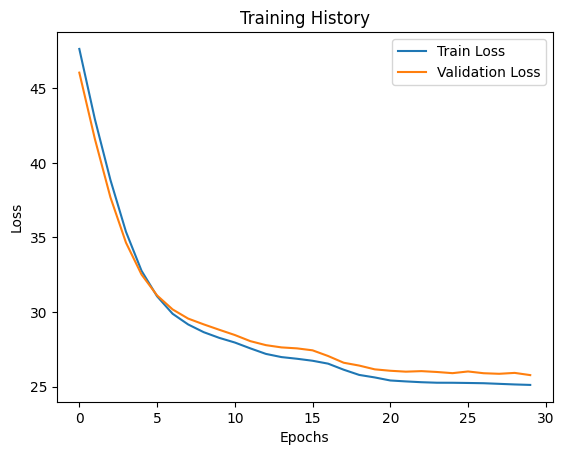

In [ ]:
# plot training history
plt.plot(vae_fit.history['loss'], label='Train Loss')
plt.plot(vae_fit.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def generate_random_images(decoder, latent_dim, n=10):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))

    # Decode them into images
    generated = decoder.predict(z_random)

    # Plot
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i].squeeze()  # shape (28,28) or (28,28,1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


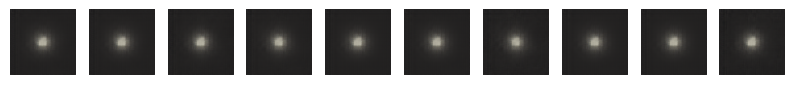

In [ ]:
# generate and visualize generated galaxy images
generate_random_images(decoder, latent_dim=2, n=10)